<a href="https://colab.research.google.com/github/sifakhru/male-female-eyes-classification/blob/main/ImageClassification_MaleFemaleEyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification: Male Female Eyes**

Proyek image classification untuk mengklasifikasikan gender berdasarkan mata.



> **Created by sifakhru on GitHub**

## Mengimpor Library

In [ ]:
# Mengimpor library yang dibutuhkan

!pip install split_folders tqdm # untuk train_test_split

import splitfolders
import tensorflow as tf
import zipfile, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.preprocessing import image
from google.colab import files

%matplotlib inline

## Mempersiapkan Dataset

Dataset dari [Kaggle **PavelBiz** Female and Male Eyes.](https://www.kaggle.com/pavelbiz/eyes-rtte/code)

In [ ]:
files.upload()

Saving male-female-eyes.zip to male-female-eyes.zip


In [ ]:
# Unzip dataset memasukan ke folder dataset dan menghapus file .zip

!unzip male-female-eyes.zip -d dataset && rm male-female-eyes.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/maleeyes/2430.jpg  
  inflating: dataset/maleeyes/2431.jpg  
  inflating: dataset/maleeyes/2432.jpg  
  inflating: dataset/maleeyes/2433.jpg  
  inflating: dataset/maleeyes/2434.jpg  
  inflating: dataset/maleeyes/2435.jpg  
  inflating: dataset/maleeyes/2436.jpg  
  inflating: dataset/maleeyes/2437.jpg  
  inflating: dataset/maleeyes/2438.jpg  
  inflating: dataset/maleeyes/2439.jpg  
  inflating: dataset/maleeyes/244.jpg  
  inflating: dataset/maleeyes/2440.jpg  
  inflating: dataset/maleeyes/2441.jpg  
  inflating: dataset/maleeyes/2442.jpg  
  inflating: dataset/maleeyes/2443.jpg  
  inflating: dataset/maleeyes/2444.jpg  
  inflating: dataset/maleeyes/2445.jpg  
  inflating: dataset/maleeyes/2446.jpg  
  inflating: dataset/maleeyes/2448.jpg  
  inflating: dataset/maleeyes/2449.jpg  
  inflating: dataset/maleeyes/245.jpg  
  inflating: dataset/maleeyes/2450.jpg  
  inflating: dataset/maleeyes/2452.jpg  
  inflat

In [ ]:
# Memasukan dataset

data_dir = '/content/dataset'

In [ ]:
# Membagi dataset menjadi 80% dan 20%

splitfolders.ratio(data_dir, 
                   output= '/content/dataset/split_dataset',
                   ratio=(0.8,0.2), 
                   group_prefix=None)

Copying files: 11525 files [00:01, 9081.46 files/s]


membagi 80:20.

In [ ]:
# Menghitung total file dalam dataset

split_path = '/content/dataset/split_dataset/'
folder_names = ['maleeyes', 'femaleeyes']

original_files ={}
train_files = {}
val_files = {}

for i in folder_names:
    original_files[i] = len(os.listdir(data_dir+'/'+i))
    train_files[i] = len(os.listdir(split_path+'train/'+i))
    val_files[i] = len(os.listdir(split_path+'val/'+i))

    
# konvert ke dalam dataframe
result_split = pd.DataFrame()
result_split = result_split.append(original_files, ignore_index=True)
result_split = result_split.append(train_files, ignore_index=True)
result_split = result_split.append(val_files, ignore_index=True)
result_split['total'] = result_split.sum(axis=1)
result_split['type'] = ['original', 'train', 'val']
result_split = result_split[['type', 'maleeyes', 'femaleeyes', 'total']]
print(result_split)

       type  maleeyes  femaleeyes    total
0  original    6323.0      5202.0  11525.0
1     train    5058.0      4161.0   9219.0
2       val    1265.0      1041.0   2306.0


Image shape (45, 45, 3)
Image shape (43, 43, 3)
Image shape (61, 61, 3)
Image shape (52, 52, 3)
Image shape (58, 58, 3)
Image shape (61, 61, 3)
Image shape (47, 47, 3)
Image shape (54, 54, 3)
Image shape (44, 44, 3)
Image shape (52, 52, 3)


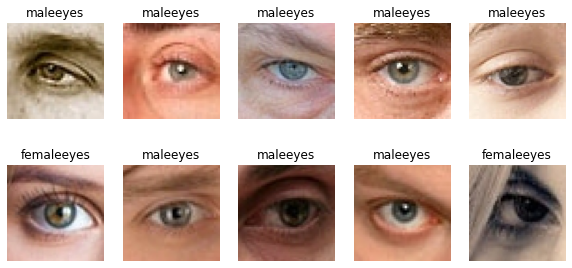

In [ ]:
# Menampilkan gambar acak pada dataset

def one_random_image(target_path, target_class): 
  target_fold = target_path + target_class
  random_image = random.sample(os.listdir(target_fold), 1)
  image = mpimg.imread(target_fold+'/'+random_image[0])
  plt.imshow(image)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {image.shape}")

  return image

def group_random_images( target_path, figure_size=(10, 10), group=10):
  plt.figure(figsize=figure_size)
  for i in range(group):
    plt.subplot(4, 5, i+1)
    class_name = random.choice(['maleeyes', 'femaleeyes'])
    image = one_random_image(target_path=target_path, target_class=class_name)
  
group_random_images = group_random_images(target_path='/content/dataset/split_dataset/train/')

In [ ]:
# Menyimpan hasil pembagian dataset ke dalam variabel

train_set = '/content/dataset/split_dataset/train'
val_set = '/content/dataset/split_dataset/val'

In [ ]:
# Melakukan Augmentasi

train_aug = ImageDataGenerator(
       rescale=1./255,
       rotation_range=20,
       horizontal_flip=True,
       zoom_range=0.2,
       shear_range = 0.2,
       fill_mode = 'nearest')

val_aug = ImageDataGenerator(
      rescale=1./255,
      shear_range= 0.2,
      fill_mode= 'nearest',)

In [ ]:
# Membuat ImageDataGenerator

train_generator = train_aug.flow_from_directory(
        train_set,  
        target_size=(75, 75),  
        class_mode='binary',
        batch_size=32)

val_generator = val_aug.flow_from_directory(
        val_set, 
        target_size=(75, 75),
        class_mode='binary', 
        batch_size=32)

Found 9219 images belonging to 2 classes.
Found 2306 images belonging to 2 classes.


lebih dari 10000 data.

## Membangun Model

In [ ]:
# Membangun Model Sequential

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (75,75,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation= 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

model sequential, menggunakan Conv2D - MaxPooling2D.

In [ ]:
# Menampilkan model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
# Compile model

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# fungsi Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92):
      print('\nAkurasi memenuhi target!')
      self.model.stop_training = True

callbacks = myCallback()

menggunakan fungsi callback.

## Melatih Model

In [ ]:
# Melatih model dengan fit

history = model.fit(
    train_generator,
    epochs=50,
    validation_data = val_generator,
    callbacks=[callbacks],
)

Epoch 1/50
289/289 [==============================] - 52s 70ms/step - loss: 0.6066 - accuracy: 0.6680 - val_loss: 0.4670 - val_accuracy: 0.7801
Epoch 2/50
289/289 [==============================] - 20s 69ms/step - loss: 0.4666 - accuracy: 0.7852 - val_loss: 0.3698 - val_accuracy: 0.8504
Epoch 3/50
289/289 [==============================] - 20s 69ms/step - loss: 0.3997 - accuracy: 0.8219 - val_loss: 0.3304 - val_accuracy: 0.8699
Epoch 4/50
289/289 [==============================] - 20s 68ms/step - loss: 0.3626 - accuracy: 0.8398 - val_loss: 0.3515 - val_accuracy: 0.8495
Epoch 5/50
289/289 [==============================] - 20s 69ms/step - loss: 0.3334 - accuracy: 0.8551 - val_loss: 0.2611 - val_accuracy: 0.8968
Epoch 6/50
289/289 [==============================] - 20s 69ms/step - loss: 0.3170 - accuracy: 0.8657 - val_loss: 0.3139 - val_accuracy: 0.8677
Epoch 7/50
289/289 [==============================] - 20s 69ms/step - loss: 0.3122 - accuracy: 0.8672 - val_loss: 0.2486 - val_accuracy:

akurasi > 92%

## Visualisasi Plot

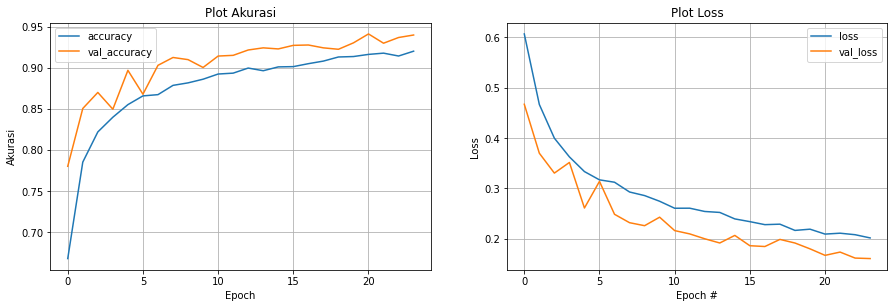

In [ ]:
# Menampilkan plot hasil pelatihan

fig = plt.figure(figsize=(8, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.subplot(2, 2, 1)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title('Plot Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('Plot Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Convert Model 

In [ ]:
export_dir='saved_model'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# Mengkonvert model ke format tflite

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
    with tf.io.gfile.GFile('eyes_detection.tflite', 'wb') as f:
      f.write(tflite_model)

model tflite tersimpan pada '/content/eyes_detection.tflite'